<a href="https://colab.research.google.com/github/shababusama/Deep_Learning_Techniques_for_Brain_Tumor_Classification_in_MRI_Images/blob/main/Brain_Tumor_Classification_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#---------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Importing the Images from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_training_dataframe(training_path):
    """
    Creates a DataFrame containing the class labels and corresponding image paths from the given training directory.

    Parameters:
    training_path (str): Path to the directory containing subdirectories of images, where each subdirectory is named after its class label.

    Returns:
    pd.DataFrame: A DataFrame with two columns - 'Image Path' and 'Class Label'.
    """
    class_labels, image_paths = zip(*[
        (label, os.path.join(training_path, label, image))
        for label in os.listdir(training_path) if os.path.isdir(os.path.join(training_path, label))
        for image in os.listdir(os.path.join(training_path, label))
    ])

    training_df = pd.DataFrame({'Image Path': image_paths, 'Class Label': class_labels})
    return training_df

def create_test_dataframe(test_path):
    """
    Creates a DataFrame containing the class labels and corresponding image paths from the given test directory.

    Parameters:
    test_path (str): Path to the directory containing subdirectories of images, where each subdirectory is named after its class label.

    Returns:
    pd.DataFrame: A DataFrame with two columns - 'Image Path' and 'Class Label'.
    """
    class_labels, image_paths = zip(*[
        (label, os.path.join(test_path, label, image))
        for label in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, label))
        for image in os.listdir(os.path.join(test_path, label))
    ])

    test_df = pd.DataFrame({'Image Path': image_paths, 'Class Label': class_labels})
    return test_df

In [ ]:
tr_df = create_training_dataframe('/content/drive/MyDrive/MRI Brain Tumor Dataset/Training')

In [ ]:
tr_df

,Image Path,Class Label
0,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
1,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
2,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
3,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
4,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
...,...,...
5707,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma
5708,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma
5709,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma
5710,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma


In [ ]:
ts_df = create_training_dataframe('/content/drive/MyDrive/MRI Brain Tumor Dataset/Testing')

In [ ]:
ts_df

,Image Path,Class Label
0,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
1,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
2,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
3,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
4,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
...,...,...
1306,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
1307,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
1308,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
1309,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma


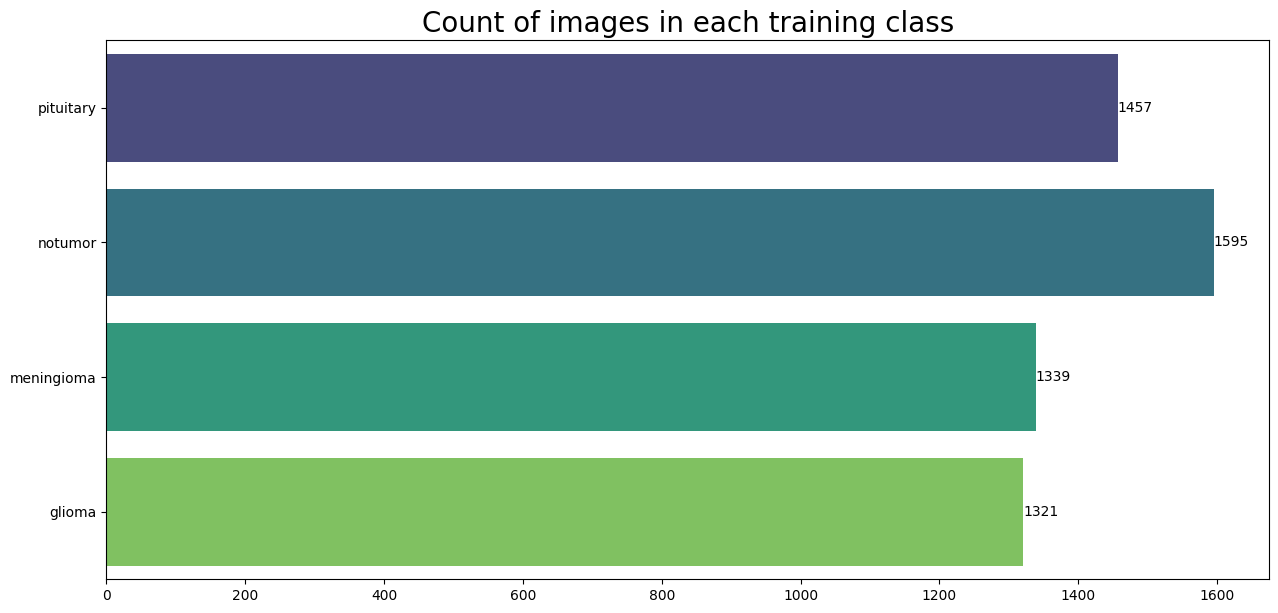

In [ ]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df, y='Class Label', palette='viridis')

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each training class', fontsize=20)

# Adding the labels to the bars
for container in ax.containers:
    ax.bar_label(container)

plt.show()

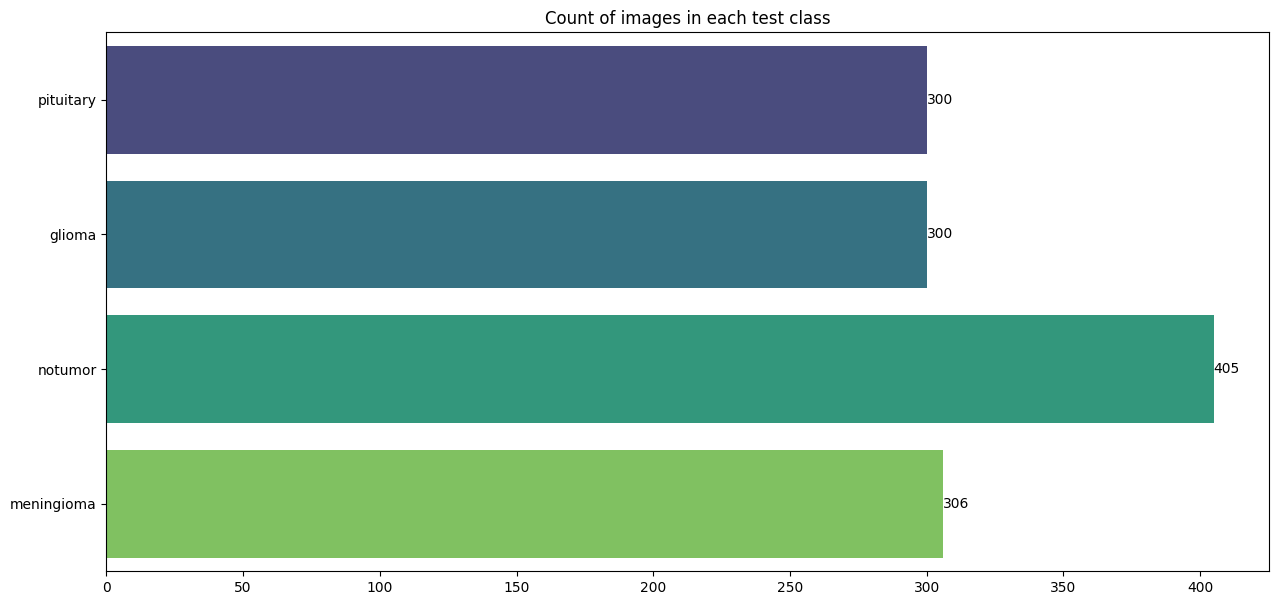

In [ ]:
# Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class Label'], data =ts_df, palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each test class')
# Adding the labels to the bars
for container in ax.containers:
    ax.bar_label(container)


plt.show()

# Data Preprocessing

Data Spliting to training testing and validation set

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class Label'])

In [ ]:
# Parameters
batch_size = 32
img_size = (224, 224)
brightness_range = (0.8, 1.2)
rescale_factor = 1/255

# Create ImageDataGenerators with parameters
train_val_gen = ImageDataGenerator(
    rescale=rescale_factor,
    brightness_range=brightness_range
)

test_gen = ImageDataGenerator(rescale=rescale_factor)

# Function to create generators from dataframes
def create_generators(tr_df, valid_df, ts_df, batch_size, img_size):
    if tr_df.empty or valid_df.empty or ts_df.empty:
        raise ValueError("One of the dataframes is empty. Please check your dataframes.")

    train_gen = train_val_gen.flow_from_dataframe(
        tr_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=batch_size,
        target_size=img_size
    )

    valid_gen = train_val_gen.flow_from_dataframe(
        valid_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=batch_size,
        target_size=img_size
    )

    test_gen_flow = test_gen.flow_from_dataframe(
        ts_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=16,
        target_size=img_size,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen_flow

# Assuming tr_df, valid_df, ts_df are defined and not empty
train_gen, valid_gen, test_gen_flow = create_generators(tr_df, valid_df, ts_df, batch_size, img_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Getting samples from data

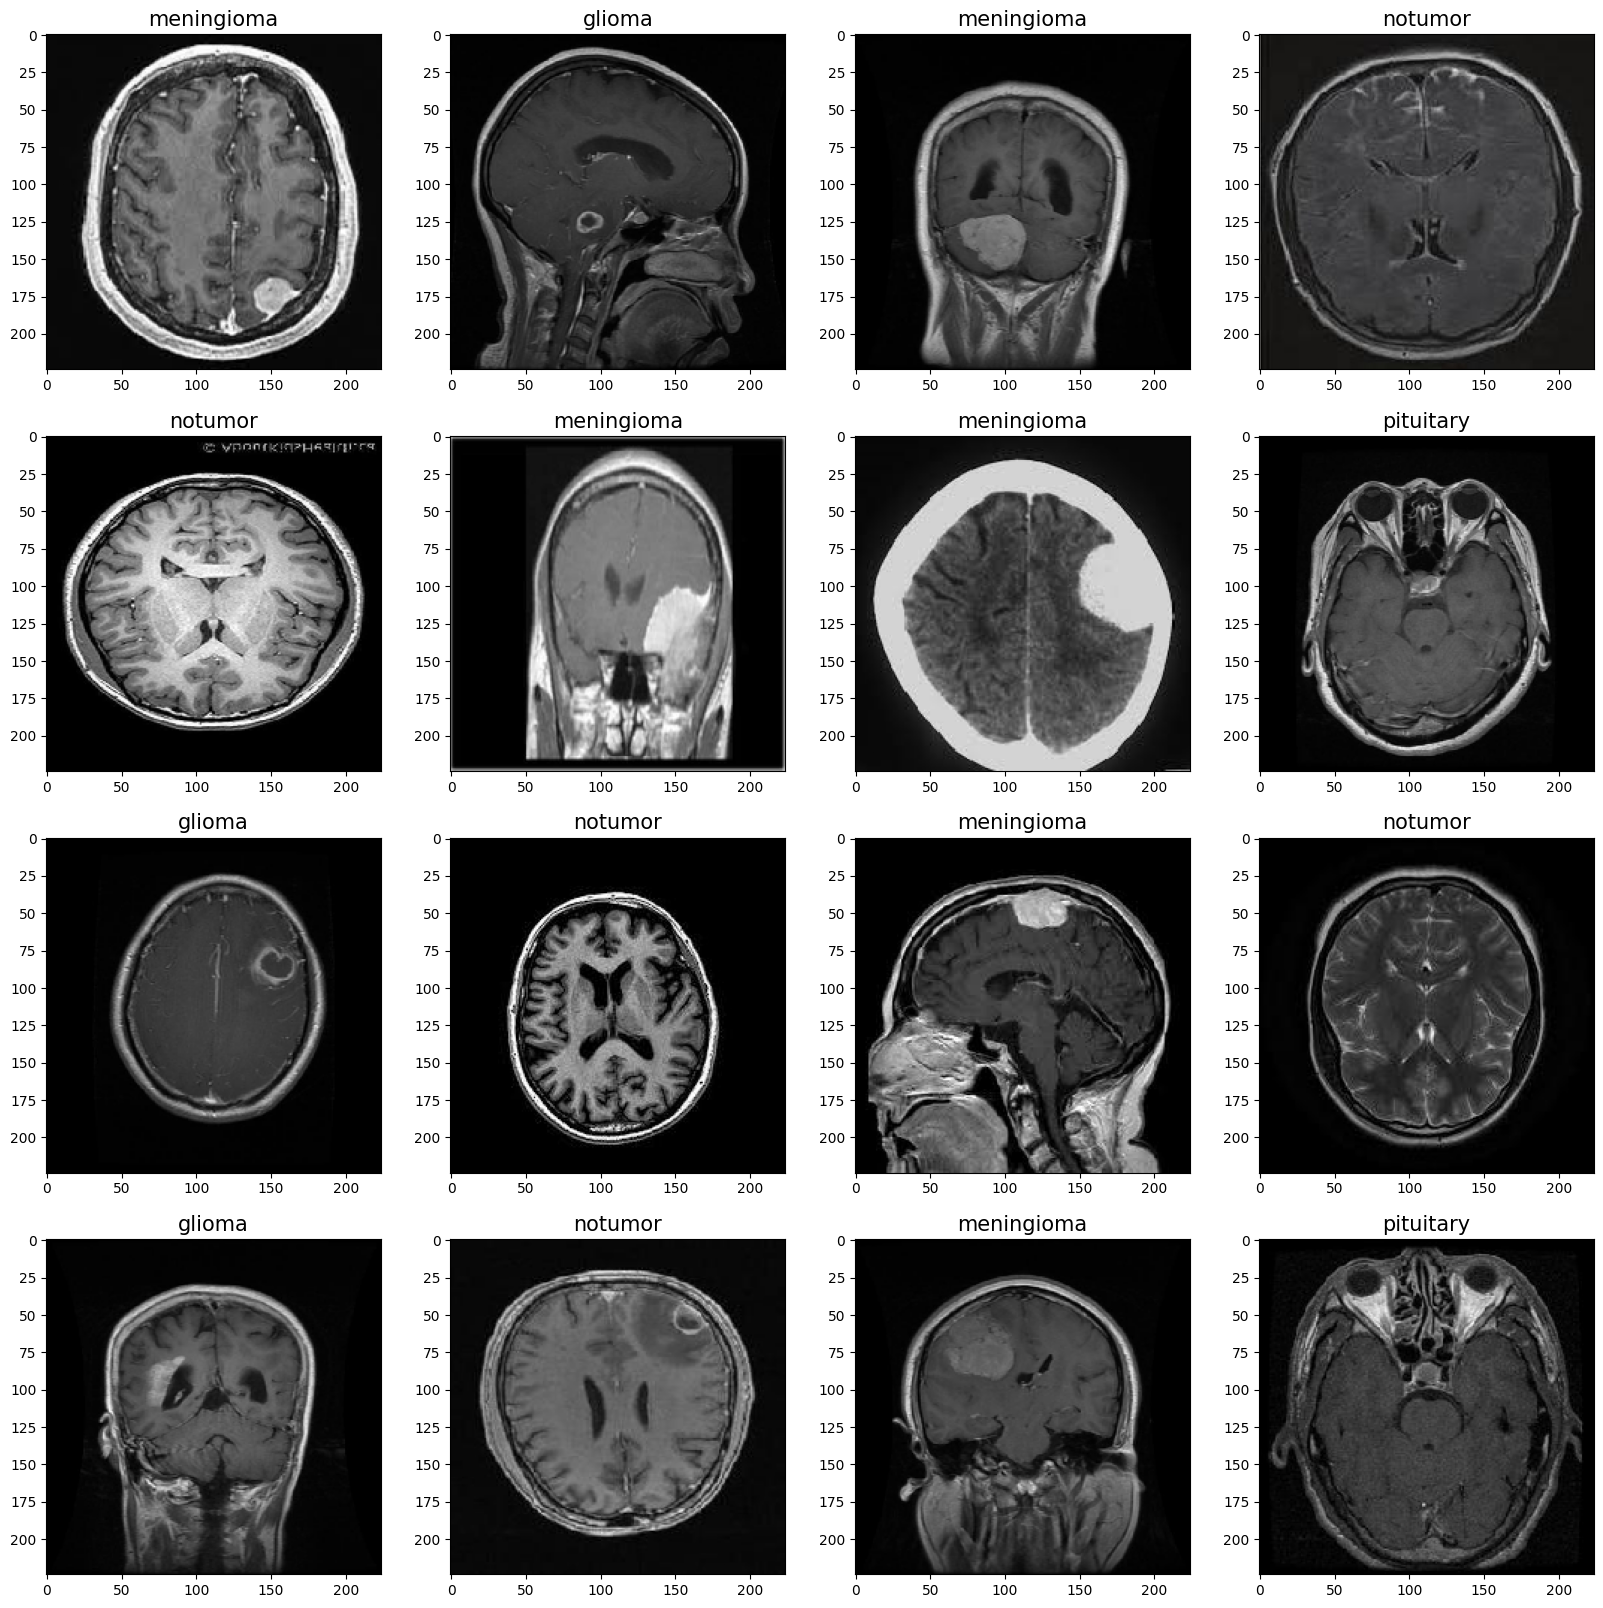

In [ ]:
# Get class indices from the training generator
class_dict = train_gen.class_indices
# Create a list of class names from the dictionary keys
classes = list(class_dict.keys())
# Fetch the next batch of images and labels from the test generator
images, labels = next(test_gen_flow)

# Set the figure size for the plot
plt.figure(figsize=(20, 20))

# Iterate over the images and their corresponding labels
for i, (image, label) in enumerate(zip(images, labels)):
    # Create a subplot in a 4x4 grid
    plt.subplot(4, 4, i + 1)
    # Display the image
    plt.imshow(image)
    # Find the index of the highest value in the one-hot encoded label
    class_name = classes[np.argmax(label)]
    # Set the title of the subplot to the class name
    plt.title(class_name, color='k', fontsize=15)

# Display the figure with all subplots
plt.show()

# CNN Model Design

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# Build the model
model = Sequential([
    # Block 1
    Conv2D(filters=64, kernel_size=(4,4), padding="same", activation="relu", input_shape= img_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=64, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 2
    Conv2D(filters=128, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=128, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 3
    Conv2D(filters=256, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=256, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=256, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),  # Adjusted pooling size
    Dropout(0.1),  # Adding Dropout

    # Block 4
    Conv2D(filters=512, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),  # Adjusted pooling size
    Dropout(0.1),  # Adding Dropout

    # Block 5
    Conv2D(filters=512, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(4,4), padding="same", activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),  # Adjusted pooling size
    Dropout(0.1),  # Adding Dropout

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),  # Adding Dropout
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),  # Adding Dropout
    Dense(class_count, activation="softmax")  # Output layer with softmax activation
])

In [ ]:
# Compile the model
model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 32,612,548 (124.41 MB)

 Trainable params: 32,604,100 (124.37 MB)

 Non-trainable params: 8,448 (33.00 KB)

# Training the Network

In [ ]:
# Define callbacks for early stopping, learning rate reduction, and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(train_gen, epochs=30, verbose=1, validation_data=valid_gen, shuffle=False,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 1646s 9s/step - accuracy: 0.5714 - loss: 5.7006 - val_accuracy: 0.2336 - val_loss: 6.2540 - learning_rate: 1.0000e-04
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7709 - loss: 5.0425 - val_accuracy: 0.3344 - val_loss: 5.9834 - learning_rate: 1.0000e-04
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8060 - loss: 4.9354 - val_accuracy: 0.5405 - val_loss: 5.5774 - learning_rate: 1.0000e-04
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8425 - loss: 4.8499 - val_accuracy: 0.6412 - val_loss: 5.3818 - learning_rate: 1.0000e-04
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8675 - loss: 4.7868 - val_accuracy: 0.7206 - val_loss: 5.3421 - learning_rate: 1.0000e-04
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8908 - loss: 4.7083 - val_accuracy: 0.8137 - val_loss: 4.9107 - learning_rate: 1.0000e-04
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - ac

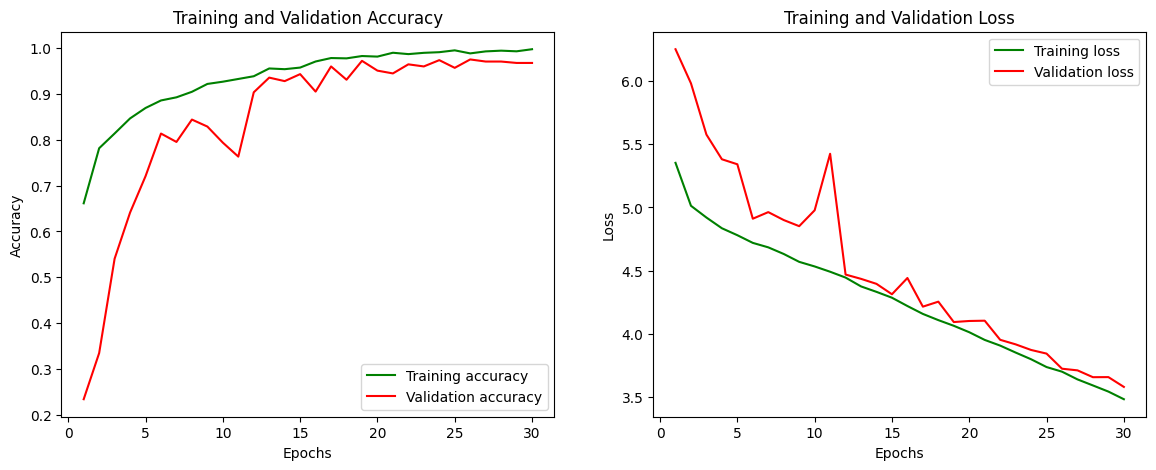

In [ ]:
# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen_flow, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict on the test set
test_pred = model.predict(test_gen_flow)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_gen_flow.classes


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9802 - loss: 3.5681
Test Loss: 3.5439746379852295
Test Accuracy: 0.9786585569381714
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step


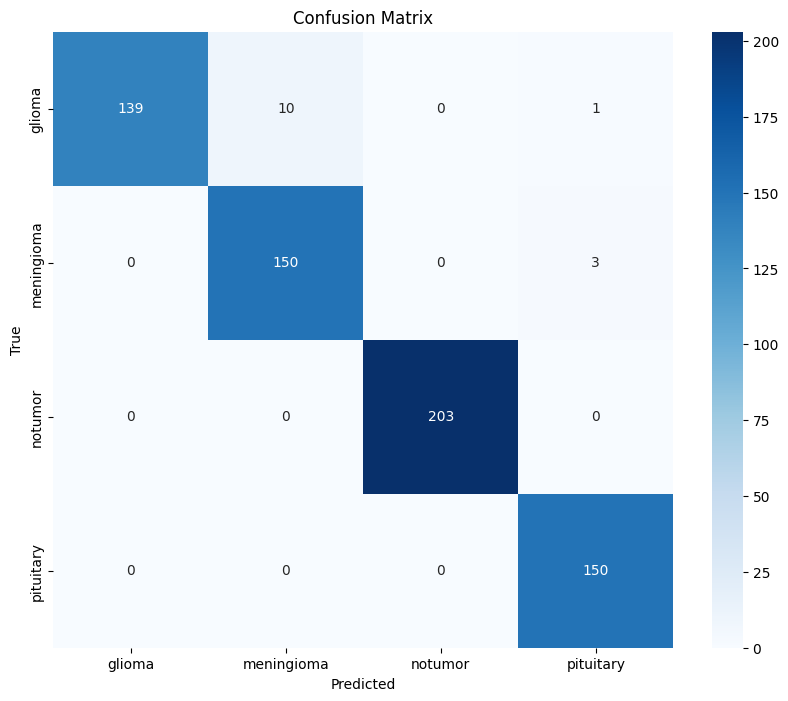

              precision    recall  f1-score   support

      glioma       1.00      0.93      0.96       150
  meningioma       0.94      0.98      0.96       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.97      1.00      0.99       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [ ]:
# Plot the confusion matrix
def plot_confusion_matrix(true_classes, pred_classes, class_names):
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Get class names
class_names = list(test_gen_flow.class_indices.keys())

# Plot confusion matrix
plot_confusion_matrix(test_true_classes, test_pred_classes, class_names)

# Print classification report
print(classification_report(test_true_classes, test_pred_classes, target_names=class_names))

# Saving the Model

In [ ]:
# Save the entire model
model.save('/content/drive/MyDrive/Osama/CNN_model.keras')

# Transfer Learning

In [ ]:
# Load the pre-trained VGG16 model without the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

In [ ]:
# Freeze all layers except the last two
for layer in vgg16_base.layers[:-2]:
    layer.trainable = False

In [ ]:
# Build the model
model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(class_count, activation="softmax")  # Output layer with softmax activation
])


# Compiling the Model

In [ ]:
# Compile the model
model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define callbacks for early stopping, learning rate reduction, and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Osama/vgg16_fine_tuned_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(train_gen, epochs=30, verbose=1, validation_data=valid_gen, shuffle=False,
                    callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.6087 - loss: 1.1141
Epoch 1: val_loss improved from inf to 0.70849, saving model to /content/drive/MyDrive/Osama/vgg16_fine_tuned_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 184s 790ms/step - accuracy: 0.6093 - loss: 1.1125 - val_accuracy: 0.7359 - val_loss: 0.7085 - learning_rate: 1.0000e-04
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8179 - loss: 0.5144
Epoch 2: val_loss improved from 0.70849 to 0.49479, saving model to /content/drive/MyDrive/Osama/vgg16_fine_tuned_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 526ms/step - accuracy: 0.8180 - loss: 0.5140 - val_accuracy: 0.8351 - val_loss: 0.4948 - learning_rate: 1.0000e-04
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9018 - loss: 0.2932
Epoch 3: val_loss improved from 0.49479 to 0.32811, saving model to /content/drive/MyDrive/Osama/vgg16_fine_tuned_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 525ms/step - accuracy: 0.9017 - 

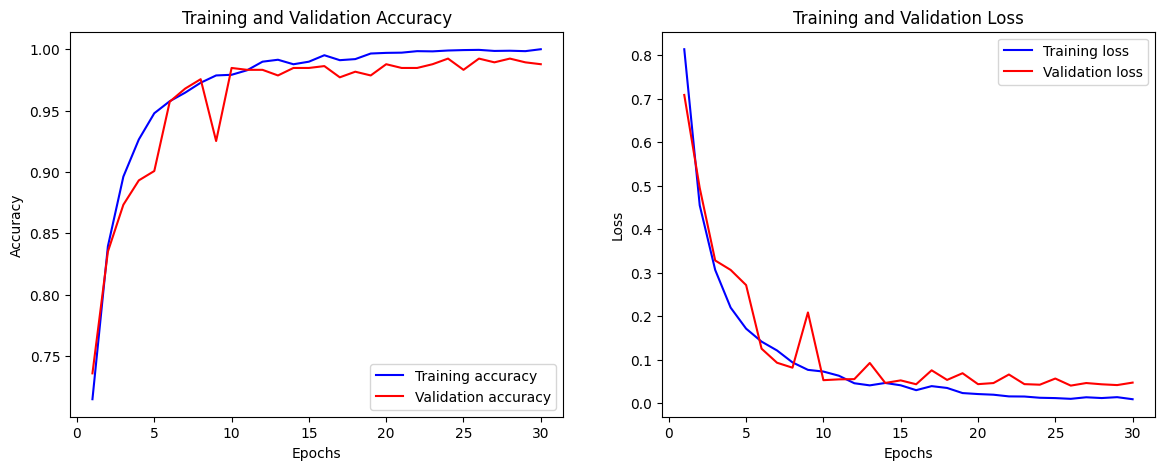

In [ ]:
# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen_flow, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict on the test set
test_pred = model.predict(test_gen_flow)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_gen_flow.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9993 - loss: 0.0041
Test Loss: 0.011633417569100857
Test Accuracy: 0.9969512224197388
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step


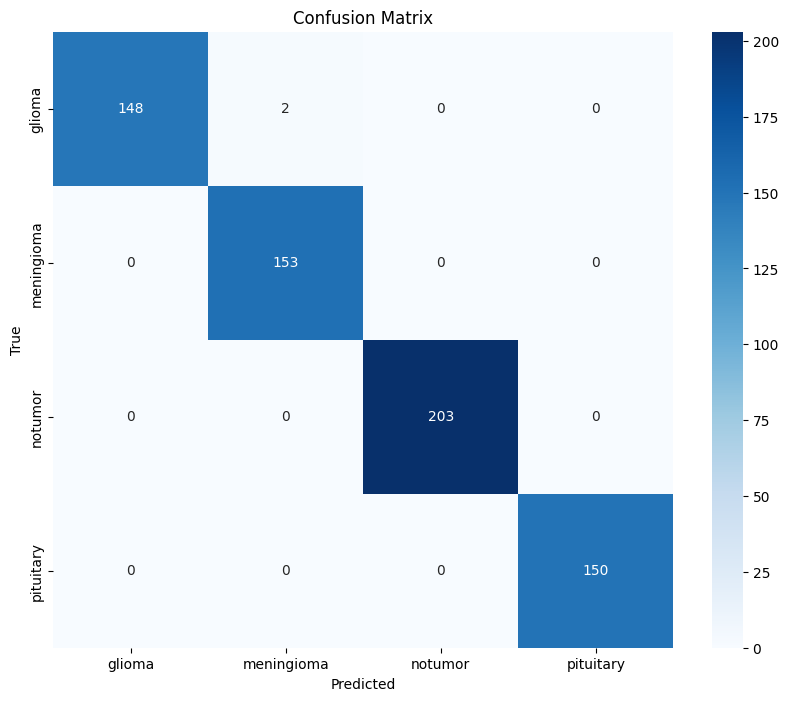

              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       150
  meningioma       0.99      1.00      0.99       153
     notumor       1.00      1.00      1.00       203
   pituitary       1.00      1.00      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



In [ ]:
# Plot the confusion matrix
def plot_confusion_matrix(true_classes, pred_classes, class_names):
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Get class names
class_names = list(test_gen_flow.class_indices.keys())

# Plot confusion matrix
plot_confusion_matrix(test_true_classes, test_pred_classes, class_names)

# Print classification report
print(classification_report(test_true_classes, test_pred_classes, target_names=class_names))